<a href="https://colab.research.google.com/github/mcurry572/4540/blob/main/HW13_WaveNet_Michael_curry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # cuda means it is using a GPU
print(f"Using device: {device}")

Using device: cuda


In [10]:
# Generate a 1-second sine wave (440Hz)
def generate_sine_wave(seq_len=16000, freq=440, sample_rate=16000):
    t = np.linspace(0, 1, seq_len)
    return np.sin(2 * np.pi * freq * t).astype(np.float32)

# Prepare input and target tensors
wave = generate_sine_wave()
X = torch.tensor(wave[:-1]).unsqueeze(0).unsqueeze(0)  # (batch, channel, time)
Y = torch.tensor(wave[1:]).unsqueeze(0).unsqueeze(0)   # shifted target

X, Y = X.to(device), Y.to(device)

In [11]:
# Causal Convolution Layer
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.pad = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=self.pad, dilation=dilation)

    def forward(self, x):
        out = self.conv(x)
        return out[:, :, :-self.pad]

# Mini WaveNet Model
class SimpleWaveNet(nn.Module):
    def __init__(self, residual_channels=32, skip_channels=64, dilation_depth=5):
        super().__init__()
        self.dilated_layers = nn.ModuleList()
        self.skip_conns = nn.ModuleList()

        for i in range(dilation_depth):
            dilation = 2 ** i
            self.dilated_layers.append(CausalConv1d(1 if i == 0 else residual_channels,
                                                    residual_channels, kernel_size=2, dilation=dilation))
            self.skip_conns.append(nn.Conv1d(residual_channels, skip_channels, 1))

        self.output = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(skip_channels, skip_channels, 1),
            nn.ReLU(),
            nn.Conv1d(skip_channels, 1, 1)
        )

    def forward(self, x):
        skip = 0
        for layer, skip_conn in zip(self.dilated_layers, self.skip_conns):
            x = torch.tanh(layer(x))
            skip += skip_conn(x)
        return self.output(skip)

In [12]:
model = SimpleWaveNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training
for epoch in range(2):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = loss_fn(output, Y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


Epoch 1, Loss: 0.509736
Epoch 2, Loss: 0.459011


In [13]:
# Generate an audio sample step-by-step
model.eval()
initial_input = X[:, :, :1]  # one sample to start
generated = [initial_input.squeeze().item()]

with torch.no_grad():
    current_input = initial_input
    for _ in range(1000):
        out = model(current_input)
        next_sample = out[:, :, -1:].detach()
        generated.append(next_sample.squeeze().item())
        current_input = torch.cat([current_input, next_sample], dim=2)

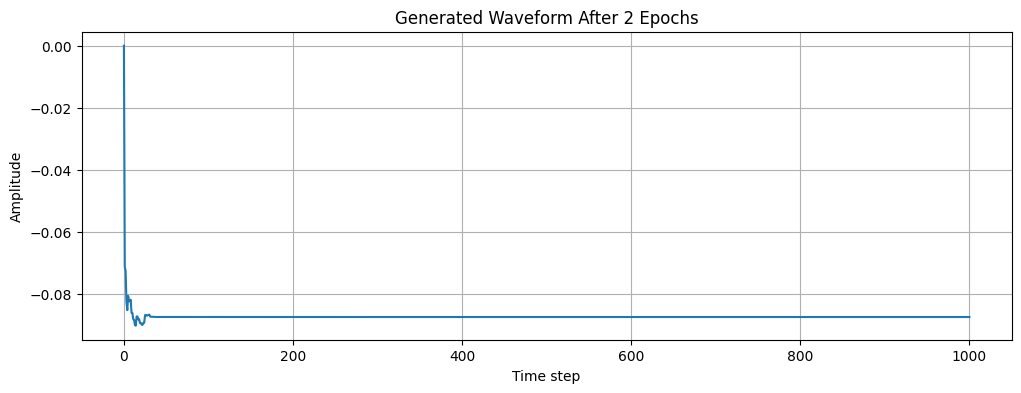

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(generated)
plt.title("Generated Waveform After 2 Epochs")
plt.xlabel("Time step")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [15]:
from IPython.display import Audio
audio_np = np.array(generated)
audio_np = audio_np / np.max(np.abs(audio_np))
sample_rate = 17000
Audio(audio_np, rate=sample_rate)


As of now the quality is not the best. After a 10 or so milliseconds the amplitude is no longer changing. I have not been able to make it run for the whole audio clip.

What needs to be added to improve
  More epochs need to be added. If there were 10 or more epochs I would get a smoother and more realistic output.

  If I were to use a longer training sequence, I could get a better audio output that could be a couple seconds long.

  Normalizing the inputs and the outputs would improve the training.


